In [20]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from skimage.feature import hog
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from collections import deque
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import cv2
import glob
import time
%matplotlib inline

In [63]:
def read_images(image_paths):
    images = []
    for image_path in image_paths:
        images.append(mpimg.imread(image_path))
    return images

def display_two_images(img1, img2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1, cmap='gray')
    ax1.set_title('First Image', fontsize=30)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title('Second Image', fontsize=30)
    
def display_random_image(image_list, count=1):
    for i in range(count):
        idx = np.random.randint(0, len(image_list)-1)
        plt.imshow(image_list[idx])
    
def data_show(car_list, notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    example_img = mpimg.imread(car_list[0])
    data_dict["image_shape"] = example_img.shape
    data_dict["data_type"] = example_img.dtype
    return data_dict

# function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

# function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features

# function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

# function to extract features from a list of images
def extract_features2(imgs, color_space='RGB', spatial_size=(16, 16), hist_bins=32, orient=9, pix_per_cell=8,
                     cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features

def extract_features(imgs, color_space='RGB', spatial_size=(16, 16), hist_bins=32, orient=9, pix_per_cell=8,
                     cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        file_features = single_image_features(image, color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block,
                            hog_channel, spatial_feat, hist_feat, hog_feat)
        features.append(file_features)
    return features

def single_image_features(image, color_space='RGB', spatial_size=(16, 16), hist_bins=32, orient=9, pix_per_cell=8,
                     cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True):
    file_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        file_features.append(hog_features)
    return np.concatenate(file_features)


def get_scaled_features(car_features, notcar_features, return_scaler=False):
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    if return_scaler:
            return scaled_X, X_scaler
    return scaled_X

# function that takes an image, start and stop positions in both x and y,
# window size (x and y dimensions), and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def search_windows(img, windows, clf, scaler, color_space='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                    orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_image_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        features_reshape = (np.array(features)).reshape(1, -1)
        test_features = scaler.transform(features_reshape)
        #test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis=False):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    #ctrans_tosearch = ctrans_tosearch.astype(np.float32)/255 #rescale down to 0-1
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            X_temp = np.hstack((spatial_features, hist_features, hog_features))
            X_temp_reshape = X_temp.reshape(1, -1)
            test_features = X_scaler.transform( X_temp_reshape ) 
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                if vis:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    plt.imshow(draw_img)
                bboxes.append(bbox)
    return bboxes


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_heat_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

In [3]:
#data load
non_car_image_paths = glob.glob('non-vehicles/*/*.png')
car_image_paths = glob.glob('vehicles/*/*.png')
test_image_paths = glob.glob('test_images/*.jpg')

In [ ]:
#Data Exploration
car_images = read_images(car_image_paths)
print("num of car image samples: {}".format(len(car_images)))
non_car_images = read_images(non_car_image_paths)
print("num of car image samples: {}".format(len(non_car_images)))
print(data_show(car_image_paths, non_car_image_paths))
test_images = read_images(test_image_paths)
display_random_image(test_images)
print("done with data exploration")

In [4]:
#Extract features
feature_t = time.time()
car_features = extract_features(car_image_paths, color_space='YCrCb', spatial_size=(16, 16), hog_channel='ALL')
notcar_features = extract_features(non_car_image_paths, color_space='YCrCb', spatial_size=(16, 16), hog_channel='ALL')
scaled_X, X_scaler = get_scaled_features(car_features, notcar_features, return_scaler=True)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.25, random_state=rand_state)
print("done with feature extraction in {}".format((time.time() - feature_t)))

/Users/amalpani/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


done with feature extraction in 94.35597705841064


In [5]:
print("train feature shape: {}".format(X_train.shape))
print("test feature shape: {}".format(X_train.shape))
X_train, y_train = shuffle(X_train, y_train)
print("shuffle done")

train feature shape: (13320, 6156)
test feature shape: (13320, 6156)
shuffle done


In [6]:
#Classfier
#After running Grid Search and getting the best values for C
#parameters = {'C':[0.5, 1, 10]}
#svc = GridSearchCV(svc, parameters)
#print("clf best params: {}".format(svc.best_params_))
t = time.time()
svc = LinearSVC(C=0.5)
svc.fit(X_train, y_train)
model_done_t = time.time()
print("done fitting in {}".format((model_done_t - t)))
pred = svc.predict(X_test)
predict_done_t = time.time()
print("done predicting: {}".format((predict_done_t - model_done_t)))
acc = accuracy_score(pred, y_test)
print("accuracy score: {}".format(acc))

done fitting in 19.431626081466675
done predicting: 0.05195188522338867
accuracy score: 0.9835585585585586


In [101]:
def pipeline(image):
    #variables
    color_space = 'YCrCb'
    orient = 9  
    pix_per_cell = 8 
    cell_per_block = 2 
    hog_channel = 'ALL'
    spatial_size = (16, 16) 
    hist_bins = 32 
    spatial_feat = True 
    hist_feat = True 
    hog_feat = True 
    iterations = [(400, 470, 1), (400, 600, 1.5), (400, None, 2.0), (400, None, 2.5)]
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    global heat_collect
    
    #img copy
    draw_img = np.copy(image)
    
    positive_detections = []
    for iter in iterations:
        ystart = iter[0]
        ystop = iter[1]
        scale = iter[2]
        found_boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        if len(found_boxes) != 0:
            positive_detections.extend(found_boxes)
    if len(positive_detections) != 0:
        heatmap = add_heat(heat, positive_detections)
        heat_collect.append(heatmap)
        heatmap = np.average(heat_collect, axis=0)
        heatmap = apply_heat_threshold(heatmap, 2)
        corrected_heatmap = np.clip(heatmap, 0, 255)
        labels = label(corrected_heatmap)
        finalized = draw_labeled_bboxes(draw_img, labels)
        return finalized
    return image

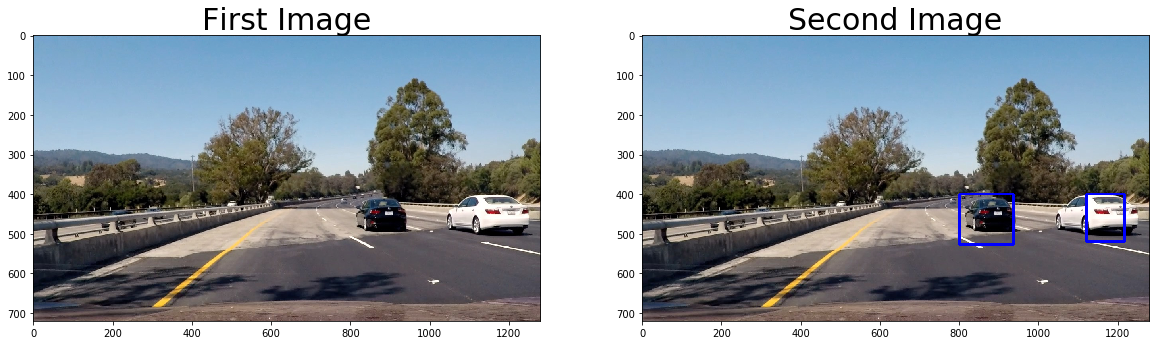

In [103]:
image = mpimg.imread('./test_images/test4.jpg')
x_img = pipeline(image)
display_two_images(image, x_img)

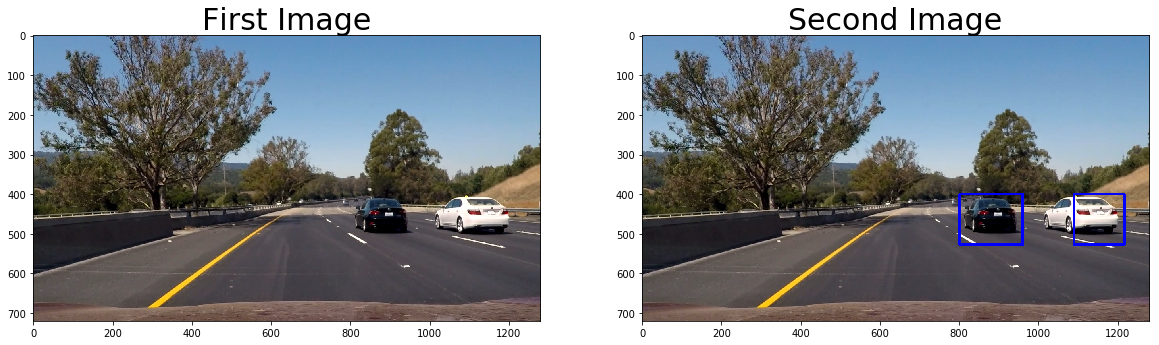

In [104]:
image = mpimg.imread('./test_images/test6.jpg')
x_img = pipeline(image)
display_two_images(image, x_img)

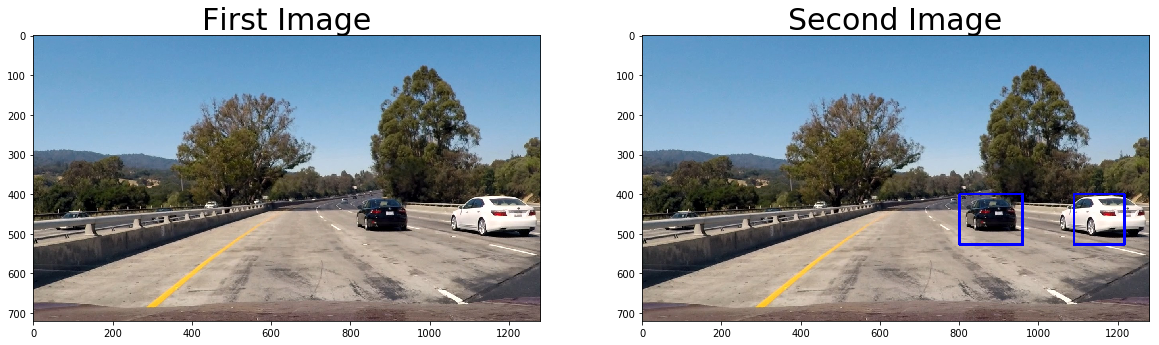

In [105]:
image = mpimg.imread('./test_images/test1.jpg')
x_img = pipeline(image)
display_two_images(image, x_img)

In [80]:
heat_collect = deque(maxlen=15)

output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:01<25:25,  1.21s/it]

  0%|          | 2/1261 [00:02<25:20,  1.21s/it]

  0%|          | 3/1261 [00:03<27:05,  1.29s/it]

  0%|          | 4/1261 [00:05<27:11,  1.30s/it]

  0%|          | 5/1261 [00:06<26:28,  1.26s/it]

  0%|          | 6/1261 [00:07<26:10,  1.25s/it]

  1%|          | 7/1261 [00:08<25:46,  1.23s/it]

  1%|          | 8/1261 [00:10<26:02,  1.25s/it]

  1%|          | 9/1261 [00:11<26:41,  1.28s/it]

  1%|          | 10/1261 [00:12<26:06,  1.25s/it]

  1%|          | 11/1261 [00:13<25:55,  1.24s/it]

  1%|          | 12/1261 [00:15<26:31,  1.27s/it]

  1%|          | 13/1261 [00:16<26:04,  1.25s/it]

  1%|          | 14/1261 [00:17<25:28,  1.23s/it]

  1%|          | 15/1261 [00:19<26:50,  1.29s/it]

  1%|▏         | 16/1261 [00:20<28:29,  1.37s/it]

  1%|▏         | 17/1261 [00:21<27:44,  1.34s/it]

  1%|▏         | 18/1261 [00:23<28:31,  1.38s/it]

  2%|▏         | 19/1261 [00:24<28:56,  1.40s/i

 11%|█▏        | 143/1261 [03:06<25:00,  1.34s/it]

 11%|█▏        | 144/1261 [03:07<24:26,  1.31s/it]

 11%|█▏        | 145/1261 [03:08<23:48,  1.28s/it]

 12%|█▏        | 146/1261 [03:09<23:17,  1.25s/it]

 12%|█▏        | 147/1261 [03:10<22:45,  1.23s/it]

 12%|█▏        | 148/1261 [03:12<23:08,  1.25s/it]

 12%|█▏        | 149/1261 [03:13<25:04,  1.35s/it]

 12%|█▏        | 150/1261 [03:15<24:35,  1.33s/it]

 12%|█▏        | 151/1261 [03:16<23:37,  1.28s/it]

 12%|█▏        | 152/1261 [03:17<22:59,  1.24s/it]

 12%|█▏        | 153/1261 [03:18<23:01,  1.25s/it]

 12%|█▏        | 154/1261 [03:19<23:02,  1.25s/it]

 12%|█▏        | 155/1261 [03:21<22:37,  1.23s/it]

 12%|█▏        | 156/1261 [03:22<22:37,  1.23s/it]

 12%|█▏        | 157/1261 [03:23<22:17,  1.21s/it]

 13%|█▎        | 158/1261 [03:24<22:26,  1.22s/it]

 13%|█▎        | 159/1261 [03:25<22:04,  1.20s/it]

 13%|█▎        | 160/1261 [03:27<21:45,  1.19s/it]

 13%|█▎        | 161/1261 [03:28<21:57,  1.20s/it]

 13%|█▎     

 23%|██▎       | 284/1261 [06:13<21:38,  1.33s/it]

 23%|██▎       | 285/1261 [06:15<21:26,  1.32s/it]

 23%|██▎       | 286/1261 [06:16<21:11,  1.30s/it]

 23%|██▎       | 287/1261 [06:17<21:16,  1.31s/it]

 23%|██▎       | 288/1261 [06:19<21:38,  1.34s/it]

 23%|██▎       | 289/1261 [06:20<21:16,  1.31s/it]

 23%|██▎       | 290/1261 [06:21<20:59,  1.30s/it]

 23%|██▎       | 291/1261 [06:22<20:59,  1.30s/it]

 23%|██▎       | 292/1261 [06:24<21:15,  1.32s/it]

 23%|██▎       | 293/1261 [06:25<21:14,  1.32s/it]

 23%|██▎       | 294/1261 [06:26<21:12,  1.32s/it]

 23%|██▎       | 295/1261 [06:28<20:57,  1.30s/it]

 23%|██▎       | 296/1261 [06:29<21:10,  1.32s/it]

 24%|██▎       | 297/1261 [06:30<21:09,  1.32s/it]

 24%|██▎       | 298/1261 [06:32<20:57,  1.31s/it]

 24%|██▎       | 299/1261 [06:33<21:00,  1.31s/it]

 24%|██▍       | 300/1261 [06:34<21:16,  1.33s/it]

 24%|██▍       | 301/1261 [06:36<21:59,  1.37s/it]

 24%|██▍       | 302/1261 [06:37<21:38,  1.35s/it]

 24%|██▍    

 34%|███▎      | 425/1261 [09:23<18:43,  1.34s/it]

 34%|███▍      | 426/1261 [09:24<18:50,  1.35s/it]

 34%|███▍      | 427/1261 [09:25<18:40,  1.34s/it]

 34%|███▍      | 428/1261 [09:27<18:36,  1.34s/it]

 34%|███▍      | 429/1261 [09:28<18:28,  1.33s/it]

 34%|███▍      | 430/1261 [09:29<18:55,  1.37s/it]

 34%|███▍      | 431/1261 [09:31<18:53,  1.37s/it]

 34%|███▍      | 432/1261 [09:32<18:32,  1.34s/it]

 34%|███▍      | 433/1261 [09:33<18:24,  1.33s/it]

 34%|███▍      | 434/1261 [09:35<18:20,  1.33s/it]

 34%|███▍      | 435/1261 [09:36<18:14,  1.33s/it]

 35%|███▍      | 436/1261 [09:37<17:58,  1.31s/it]

 35%|███▍      | 437/1261 [09:39<17:51,  1.30s/it]

 35%|███▍      | 438/1261 [09:40<18:03,  1.32s/it]

 35%|███▍      | 439/1261 [09:41<18:38,  1.36s/it]

 35%|███▍      | 440/1261 [09:43<18:34,  1.36s/it]

 35%|███▍      | 441/1261 [09:44<18:32,  1.36s/it]

 35%|███▌      | 442/1261 [09:45<18:26,  1.35s/it]

 35%|███▌      | 443/1261 [09:47<18:11,  1.33s/it]

 35%|███▌   

 45%|████▍     | 566/1261 [12:31<15:02,  1.30s/it]

 45%|████▍     | 567/1261 [12:32<15:08,  1.31s/it]

 45%|████▌     | 568/1261 [12:33<15:04,  1.31s/it]

 45%|████▌     | 569/1261 [12:35<15:23,  1.34s/it]

 45%|████▌     | 570/1261 [12:36<15:17,  1.33s/it]

 45%|████▌     | 571/1261 [12:37<15:09,  1.32s/it]

 45%|████▌     | 572/1261 [12:38<14:58,  1.30s/it]

 45%|████▌     | 573/1261 [12:40<15:01,  1.31s/it]

 46%|████▌     | 574/1261 [12:41<14:28,  1.26s/it]

 46%|████▌     | 575/1261 [12:42<14:01,  1.23s/it]

 46%|████▌     | 576/1261 [12:43<14:12,  1.24s/it]

 46%|████▌     | 577/1261 [12:45<14:54,  1.31s/it]

 46%|████▌     | 578/1261 [12:46<14:51,  1.31s/it]

 46%|████▌     | 579/1261 [12:47<14:45,  1.30s/it]

 46%|████▌     | 580/1261 [12:49<14:31,  1.28s/it]

 46%|████▌     | 581/1261 [12:50<14:43,  1.30s/it]

 46%|████▌     | 582/1261 [12:51<14:39,  1.30s/it]

 46%|████▌     | 583/1261 [12:53<14:46,  1.31s/it]

 46%|████▋     | 584/1261 [12:54<14:43,  1.31s/it]

 46%|████▋  

 56%|█████▌    | 707/1261 [15:40<16:23,  1.77s/it]

 56%|█████▌    | 708/1261 [15:41<15:08,  1.64s/it]

 56%|█████▌    | 709/1261 [15:43<14:40,  1.59s/it]

 56%|█████▋    | 710/1261 [15:44<14:10,  1.54s/it]

 56%|█████▋    | 711/1261 [15:46<13:35,  1.48s/it]

 56%|█████▋    | 712/1261 [15:47<13:03,  1.43s/it]

 57%|█████▋    | 713/1261 [15:48<12:48,  1.40s/it]

 57%|█████▋    | 714/1261 [15:50<12:41,  1.39s/it]

 57%|█████▋    | 715/1261 [15:51<12:30,  1.37s/it]

 57%|█████▋    | 716/1261 [15:52<12:17,  1.35s/it]

 57%|█████▋    | 717/1261 [15:54<12:04,  1.33s/it]

 57%|█████▋    | 718/1261 [15:55<12:07,  1.34s/it]

 57%|█████▋    | 719/1261 [15:56<12:03,  1.33s/it]

 57%|█████▋    | 720/1261 [15:58<11:53,  1.32s/it]

 57%|█████▋    | 721/1261 [15:59<11:45,  1.31s/it]

 57%|█████▋    | 722/1261 [16:00<11:48,  1.31s/it]

 57%|█████▋    | 723/1261 [16:01<11:40,  1.30s/it]

 57%|█████▋    | 724/1261 [16:03<11:40,  1.30s/it]

 57%|█████▋    | 725/1261 [16:04<12:20,  1.38s/it]

 58%|█████▊ 

 67%|██████▋   | 848/1261 [18:47<08:53,  1.29s/it]

 67%|██████▋   | 849/1261 [18:48<08:57,  1.31s/it]

 67%|██████▋   | 850/1261 [18:49<09:05,  1.33s/it]

 67%|██████▋   | 851/1261 [18:51<09:26,  1.38s/it]

 68%|██████▊   | 852/1261 [18:52<09:23,  1.38s/it]

 68%|██████▊   | 853/1261 [18:54<09:13,  1.36s/it]

 68%|██████▊   | 854/1261 [18:55<09:14,  1.36s/it]

 68%|██████▊   | 855/1261 [18:56<09:06,  1.35s/it]

 68%|██████▊   | 856/1261 [18:58<09:00,  1.33s/it]

 68%|██████▊   | 857/1261 [18:59<09:10,  1.36s/it]

 68%|██████▊   | 858/1261 [19:00<09:09,  1.36s/it]

 68%|██████▊   | 859/1261 [19:02<09:03,  1.35s/it]

 68%|██████▊   | 860/1261 [19:03<09:04,  1.36s/it]

 68%|██████▊   | 861/1261 [19:05<09:18,  1.40s/it]

 68%|██████▊   | 862/1261 [19:06<09:13,  1.39s/it]

 68%|██████▊   | 863/1261 [19:07<09:03,  1.37s/it]

 69%|██████▊   | 864/1261 [19:08<08:49,  1.33s/it]

 69%|██████▊   | 865/1261 [19:10<08:50,  1.34s/it]

 69%|██████▊   | 866/1261 [19:11<08:44,  1.33s/it]

 69%|██████▉

 78%|███████▊  | 989/1261 [21:55<06:05,  1.35s/it]

 79%|███████▊  | 990/1261 [21:56<05:59,  1.33s/it]

 79%|███████▊  | 991/1261 [21:58<05:52,  1.31s/it]

 79%|███████▊  | 992/1261 [21:59<05:48,  1.29s/it]

 79%|███████▊  | 993/1261 [22:00<05:51,  1.31s/it]

 79%|███████▉  | 994/1261 [22:02<05:51,  1.31s/it]

 79%|███████▉  | 995/1261 [22:03<05:56,  1.34s/it]

 79%|███████▉  | 996/1261 [22:04<06:10,  1.40s/it]

 79%|███████▉  | 997/1261 [22:06<06:02,  1.37s/it]

 79%|███████▉  | 998/1261 [22:07<05:53,  1.35s/it]

 79%|███████▉  | 999/1261 [22:08<05:52,  1.35s/it]

 79%|███████▉  | 1000/1261 [22:10<05:52,  1.35s/it]

 79%|███████▉  | 1001/1261 [22:11<05:46,  1.33s/it]

 79%|███████▉  | 1002/1261 [22:12<05:45,  1.33s/it]

 80%|███████▉  | 1003/1261 [22:14<05:50,  1.36s/it]

 80%|███████▉  | 1004/1261 [22:15<05:50,  1.37s/it]

 80%|███████▉  | 1005/1261 [22:16<05:43,  1.34s/it]

 80%|███████▉  | 1006/1261 [22:18<05:43,  1.35s/it]

 80%|███████▉  | 1007/1261 [22:19<05:47,  1.37s/it]

 80%

 89%|████████▉ | 1128/1261 [25:01<03:02,  1.37s/it]

 90%|████████▉ | 1129/1261 [25:03<03:00,  1.37s/it]

 90%|████████▉ | 1130/1261 [25:04<03:05,  1.42s/it]

 90%|████████▉ | 1131/1261 [25:06<03:00,  1.39s/it]

 90%|████████▉ | 1132/1261 [25:07<02:55,  1.36s/it]

 90%|████████▉ | 1133/1261 [25:08<02:50,  1.34s/it]

 90%|████████▉ | 1134/1261 [25:10<02:50,  1.34s/it]

 90%|█████████ | 1135/1261 [25:11<02:47,  1.33s/it]

 90%|█████████ | 1136/1261 [25:12<02:46,  1.33s/it]

 90%|█████████ | 1137/1261 [25:14<02:43,  1.32s/it]

 90%|█████████ | 1138/1261 [25:15<02:42,  1.32s/it]

 90%|█████████ | 1139/1261 [25:16<02:39,  1.31s/it]

 90%|█████████ | 1140/1261 [25:17<02:37,  1.30s/it]

 90%|█████████ | 1141/1261 [25:19<02:37,  1.31s/it]

 91%|█████████ | 1142/1261 [25:20<02:36,  1.31s/it]

 91%|█████████ | 1143/1261 [25:21<02:32,  1.30s/it]

 91%|█████████ | 1144/1261 [25:23<02:32,  1.31s/it]

 91%|█████████ | 1145/1261 [25:24<02:31,  1.31s/it]

 91%|█████████ | 1146/1261 [25:25<02:32,  1.33

[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 23min 49s, sys: 3min 4s, total: 26min 53s
Wall time: 27min 58s
